In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### **4.7 LightGBM**
    - XGBoost보다 학습에 걸리는 시간이 훨씬 적고, 메모리 사용량도 상대적으로 적다.
    - XGBoost와 예측 성능은 별다른 차이가 없다.
    - 다만, 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다. (10,000건 이하의 데이터 세트)
    - 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용한다.

    * 리프 중심 트리 분할 방식: 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서
                                트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다.
    * 균형 트리 분할 방식: 최대한 균형 잡힌 트리를 유지하면서 분할되기 때문에
                           시간은 오래 걸리더라도 오버피팅에 보다 강한 구조를 가질 수 있다.


> **LightGBM 하이퍼 파라미터**

    - num_iterations [default = 100]: 반복 수행하려는 트리의 개수. 크게 지정할수록 예측 성능이 높아질 수 있으나, 과적합도 고려해야 함
    - learning_rate [default = 0.1]: 0~1, 부스팅 스텝을 반복적으로 수행할 때 없데이트되는 학습률 값
    - max_depth [default = -1]: 0보다 작은 값을 지정하면 깊이에 제한이 없음
    - max_data_in_leaf [default = 20] : = min_samples_leaf, 리프 노드가 되기 위해 최소한으로 필요한 레코드 수
    - num_leaves [default = 31]: 하나의 트리가 가질 수 있는 최대 리프 개수
    - boosting [default = gbdt]: 부스팅의 트리 생성 알고리즘. gbdt(일반적인 그래디언트 부스팅 결정 트리), rf(랜덤 포레스트)
    - bagging_fraction [default = 1.0]: 트리가 커져 과적합되는 것을 제어하기 위해 지정하는 데이터 샘플링 비율
    - feature_fraction [default = 1.0]: 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율. (과적합 제어용)
    - lambda_l2 [default = 0.0]: L2 regulation 제어를 위한 값. 값이 클수록 과적합 감소 효과
    - lambda_l1 [default = 0.0]: L1 regulation 제어를 위한 값. 과적합 제어

    - objective: 최솟값을 가져야할 손실함수를 정의

> **하이퍼 파라미터 튜닝 방안**

    num_leaves 개수를 중심으로 min_child_samples, max_depth를 함께 조정하며 모델의 복잡도를 줄인다 !

    * 과적합을 제어하기 위해 reg_lambda, reg_alpha와 같은 regularization을 적용하거나
    학습 데이터에 사용할 피처 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용할 수 있다

> **위스콘신 유방암 예측**

In [2]:
#pip install lightgbm==3.3.2

In [3]:
# LightGBM 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [4]:
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능 > 111번 반복까지 수행 후 학습 종료
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

C:\Users\homeo\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\homeo\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
 [[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.974026, F1: 0.9677, AUC: 0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

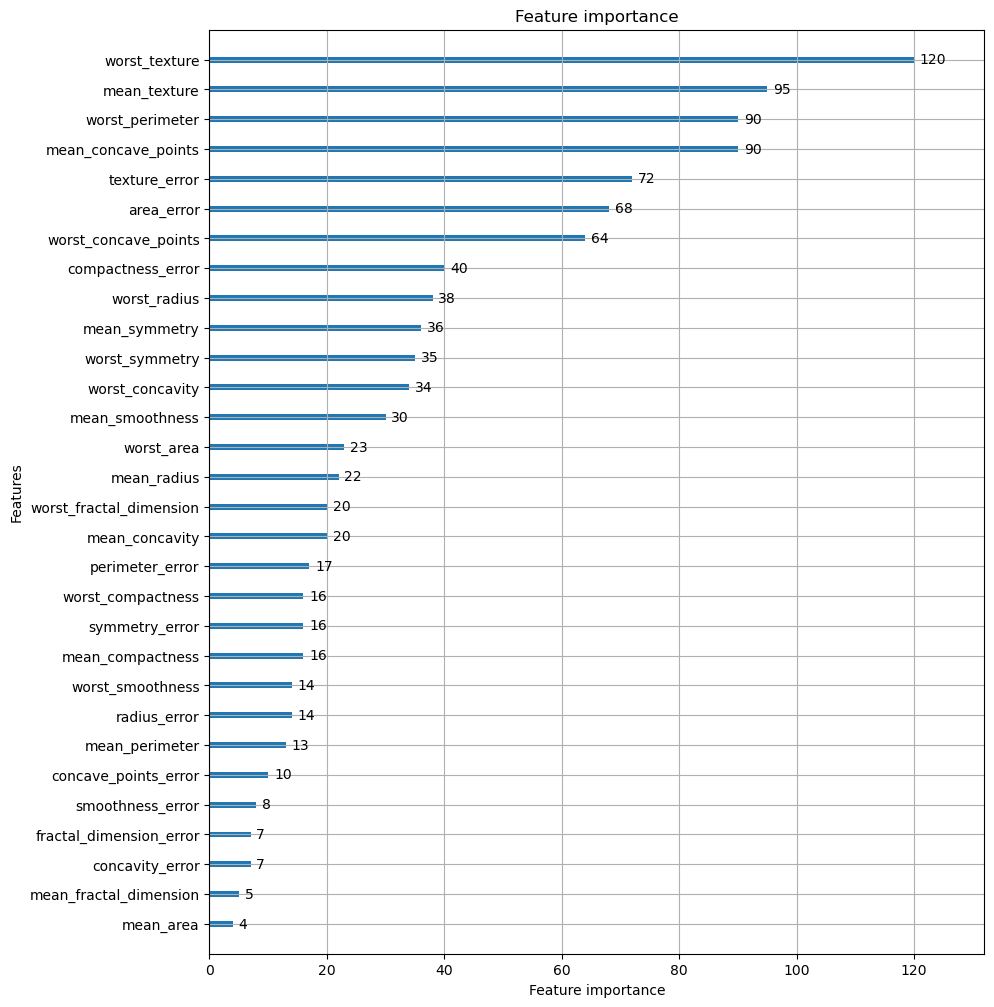

In [6]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

### **4.8 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**
    Grid Search: 튜닝해야 할 하이퍼 파라미터 개수가 많을 경우 최적화 수행 시간이 오래 걸린다 !

    특히, XGBoost나 LightGBM은 다른 알고리즘에 비해 하이퍼 파라미터의 개수가 많아
    실무의 대용량 학습 데이터에 Grid Search 방식 대신 베이지안 최적화 기법을 이용 !

> **베이지안 최적화**

    목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서
    최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식

    > 새로운 데이터를 입력 받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가며 최적 함수 모델을 생성 !

    1) 대체 모델: 획득 함수로부터 최적 함수를 예측할 수 있는 입력값을 추천 받은 뒤
                  이를 기반으로 최적 함수 모델을 개선해 나감
                  최적 함수를 추정할 때 일반적으로 가우시안 프로세스를 적용
    2) 획득 함수: 개선된 대체 모델을 기반으로 최적 입력값을 계산

    **Step 1**
    최초에는 랜덤하게 하이퍼 파라미터들을 샘플링 후 성능 결과를 관측

    **Step 2**
    관측값을 기반으로 대체 모델은 최적 함수를 추정

    **Step 3**
    추정된 최적 함수를 기반으로 획득 함수는 다음으로 관측할 하이퍼 파라미터 값을 계산.
    획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아
    다음에 관측할 하이퍼 파라미터를 대체 모델에 전달.

    **Step 4**
    획득 함수로부터 전달된 하이퍼 파라미터를 수행하여
    관측값을 기반으로 대체 모델은 갱신되어 다시 최적 함수를 예측 추정

> **HyperOpt**
    
    대체 모델이 최적 함수를 추정할 때 사용하는 트리 파르젠 알고리즘

    1) 입력 변수명과 입력값의 검색 공간 설정
    2) 목적 함수 설정
    3) 목적 함수의 반환 '최솟값'을 가지는 최적 입력값 유추

> 1) 입력 변수명과 입력값의 검색 공간 설정 (dictionary)
    
    hp.quniform(label, low, high, q): low에서 high까지 q 간격으로
    hp.uniform(label, low, high): low에서 high까지 정규 분포 형태의 검색 공간
    hp.randint(label, upper): 0부터 high까지 random한 정수값으로
    hp.loguniform(label, low, high): exp(uniform(low, high)) 반환
                                     반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간
    hp.choice(label, options): 검색 값이 문자열 or 문자열과 숫자값이 섞여 있는 경우

In [7]:
#!pip install hyperopt

In [8]:
from hyperopt import hp

# -10 ~ 10까지 1 간격을 가지는 입력 변수 x와 -15 ~ 15까지 1 간격으로 입력 변수 y 설정
search_space = {'x':hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

> 2) 목적 함수 설정
    
    반드시 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환하는 구조 !

In [9]:
from hyperopt import STATUS_OK

def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

> 3) 목적 함수의 반환 '최솟값'을 가지는 최적 입력값 유추

    fmin(fn, space, algo, max_evals, trials)

    algo: 베이지안 최적화 적용 알고리즘. 기본적으로 tpe.suggest (= HyperOpt의 기본 최적화 알고리즘인 TPE)
    max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수
    trials: 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는데 사용.
            > Trials 객체
    rstate: fmin()을 수행할 때마다 동일한 결과값을 가질 수 있도록 설정하는 랜덤 시드 값

In [10]:
from hyperopt import fmin, tpe, Trials

# 입력 결과값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변수값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5, \
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 128.78trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [11]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트 > 정답인 x=0는 도출하지 못했지만, Grid Search에 비해 적은 반복 횟수로 최적 값을 찾을 수 있다
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20, \
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 127.03trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [12]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값}
print(trial_val.results) # max_evals=20으로 20회 반복 수행의 결과

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [13]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트}
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [14]:
import pandas as pd

# results에서 loss 키값에 해당하는 values 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
print(result_df)

       x     y  losses
0   -6.0   5.0   -64.0
1   -4.0  10.0  -184.0
2    4.0  -2.0    56.0
3   -4.0  12.0  -224.0
4    9.0   1.0    61.0
5    2.0  15.0  -296.0
6   10.0   7.0   -40.0
7   -9.0 -10.0   281.0
8   -8.0   0.0    64.0
9   -0.0  -5.0   100.0
10  -0.0  -3.0    60.0
11   1.0   2.0   -39.0
12   9.0   4.0     1.0
13   6.0  10.0  -164.0
14   9.0   3.0    21.0
15   2.0   3.0   -56.0
16  -2.0 -14.0   284.0
17  -4.0  -8.0   176.0
18   7.0  11.0  -171.0
19  -0.0  -0.0     0.0


> **HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화**

    **유의사항**
    1) HyperOpt는 입력값과 반환 값이 모두 실수형이므로,
       정수 입력값만 받는 특정 하이퍼 파라미터에 대해 형변환을 해줘야 함 !
    2) HyperOpt의 목적함수는 최솟값을 반환할 수 있도록 최적화해야 하기 때문에
       좋은 성능 지표일 경우 -1을 곱해줘야 함 !
       <-> 회귀의 MAX, RMSE와 같은 성능 지표는 작을수록 좋으므로 반환 시 -1 곱할 필요 없음

    * cross_val_score()를 XGBoost, LightGBM에 적용할 경우 조기 중단이 지원되지 않으므로
      KFold로 학습/검증용 데이터 세트를 만들어 직접 교차 검증을 수행해야 함 !

In [15]:
#!pip install xgboost

In [16]:
# 위스콘신 유방암 데이터 세트
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [17]:
## 입력 변수명과 입력값의 검색 공간 설정
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth': hp.quniform('max_depth',5,20,1),
                    'min_child_weight': hp.quniform('min_child_weight',1,2,1),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [18]:
## 목적함수 설정
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값을 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}

In [19]:
## 목적 함수의 반환 '최솟값'을 가지는 최적 입력값 유추
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val,
            rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [01:06<00:00,  1.33s/trial, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.684441779397407, 'learning_rate': 0.1475201153968472, 'max_depth': 9.0, 'min_child_weight': 2.0}


In [20]:
# 실수형 값으로 도출되었으므로 최적 하이퍼 파라미터를 XGBClassifier에 인자로 입력하기 전에
# 정수형 하이퍼 파라미터는 정수형으로 형 변환을, 실수형 하이퍼 파라미터는 소수점 5자리까지만 변환
print('colsample_bytree: {0}, learning_rate: {1}, max_depth: {2}, min_child_weight: {3}'.format(
    round(best['colsample_bytree'],5), round(best['learning_rate'],5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree: 0.68444, learning_rate: 0.14752, max_depth: 9, min_child_weight: 2


In [21]:
# 도출된 최적 하이퍼 파라미터로 XGBClassifier를 재학습 후 성능 평가
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'],5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'],5))

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.55271	validation_1-logloss:0.58669
[1]	validation_0-logloss:0.46532	validation_1-logloss:0.52479
[2]	validation_0-logloss:0.39616	validation_1-logloss:0.46923
[3]	validation_0-logloss:0.34165	validation_1-logloss:0.42858
[4]	validation_0-logloss:0.29745	validation_1-logloss:0.39483
[5]	validation_0-logloss:0.25934	validation_1-logloss:0.36657
[6]	validation_0-logloss:0.22862	validation_1-logloss:0.35072
[7]	validation_0-logloss:0.20367	validation_1-logloss:0.33159
[8]	validation_0-logloss:0.18239	validation_1-logloss:0.32347
[9]	validation_0-logloss:0.16291	validation_1-logloss:0.30890
[10]	validation_0-logloss:0.14780	validation_1-logloss:0.30568
[11]	validation_0-logloss:0.13390	validation_1-logloss:0.29906
[12]	validation_0-logloss:0.12276	validation_1-logloss:0.28876


C:\Users\homeo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\homeo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.11289	validation_1-logloss:0.28343
[14]	validation_0-logloss:0.10346	validation_1-logloss:0.27987
[15]	validation_0-logloss:0.09554	validation_1-logloss:0.27622
[16]	validation_0-logloss:0.08826	validation_1-logloss:0.27372
[17]	validation_0-logloss:0.08247	validation_1-logloss:0.27294
[18]	validation_0-logloss:0.07739	validation_1-logloss:0.26674
[19]	validation_0-logloss:0.07293	validation_1-logloss:0.26352
[20]	validation_0-logloss:0.06751	validation_1-logloss:0.26310
[21]	validation_0-logloss:0.06306	validation_1-logloss:0.25711
[22]	validation_0-logloss:0.05846	validation_1-logloss:0.25678
[23]	validation_0-logloss:0.05452	validation_1-logloss:0.25732
[24]	validation_0-logloss:0.05132	validation_1-logloss:0.25525
[25]	validation_0-logloss:0.04834	validation_1-logloss:0.25395
[26]	validation_0-logloss:0.04550	validation_1-logloss:0.25433
[27]	validation_0-logloss:0.04313	validation_1-logloss:0.25181
[28]	validation_0-logloss:0.04134	validation_1-logloss:

일반적으로 Hyperopt는 무작위 검색과 베이지안 최적화를 결합하여 하이퍼파라미터 최적화를 수행합니다. 이러한 최적화 알고리즘의 특성상 실행할 때마다 결과가 다를 수 있습니다.

### **4.9 캐글 산탄데르 고객 만족 예측**
    - 370개의 피처, 1개의 Target
    - Target: 1(불만을 가진 고객), 0(만족한 고객)
    - 대부분이 만족이고 불만족인 데이터는 일부이므로 성능 평가는 ROC-AUC 사용

> **데이터 전처리**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')

In [23]:
cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [24]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [25]:
(cust_df.isnull().sum()).value_counts()

0    371
Name: count, dtype: int64

In [26]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


- 111개의 피처가 float형, 260개의 피처가 int형으로 모든 피처가 숫자형
- Null값은 없음
- TARGET에서 불만족 비율은 4%에 불과함

In [27]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [28]:
print(cust_df.var3.value_counts()[:10])

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: count, dtype: int64


- var3 칼럼의 min값 -999999 > NaN이나 특정 예외 값을 -99999로 변환했을 것 (116개)
- var3는 숫자형이고, 다른 값에 비해 -99999는 편차가 너무 심하므로 가장 값이 많은 2로 변환

In [29]:
cust_df['var3'].replace(-99999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True) # 단순 식별자이므로 drop

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_label = cust_df.iloc[:,-1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {0}, 테스트 세트 Shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습/테스트 데이터 세트 모두 TARGET 분포가 원본 데이터와 유사하게 4% 불만족 값으로 이루어짐

In [31]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. XGBoost의 조기중단의 검증 데이터 세트로 사용하기 위해
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

> **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators=500
xgb_clf = XGBClassifier(n_estimators=500, random_state=156, learning_rate=0.05)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score)) # 약 0.8414

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85101	validation_1-auc:0.81966
[12]	validation_0-auc:0.85215	validation_1-auc:0.82001
[13]	validation_0-auc:0.85303	validation_1-auc:0.82047
[14]	validation_0-auc:0.85562	validation_1-auc:0.82219
[15]	validation_0-auc:0.85656	validation_1-auc:0.82298
[16]	validation_0-auc:0.85816	validation_1-auc:0.82379
[17]	validation_0-auc:0.85866	validation_1-auc:0.82369
[18]	validation_0-au

In [33]:
## 하이퍼 파라미터 튜닝
# 검색 공간 설정
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로
xgb_search_space = {'max_depth': hp.quniform('max_depth',5,15,1),
                   'min_child_weight': hp.quniform('min_child_weight',1,6,1),
                   'colsample_bytree': hp.uniform('colsample_bytree',0.5,0.95),
                   'learning_rate': hp.uniform('learning_rate', 0.01,0.2)}

In [34]:
# 목적함수 설정
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값 반환
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           colsample_bytree=search_space['colsample_bytree'],
                           learning_rate=search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [35]:
# 목적 함수의 반환 '최솟값'을 가지는 최적 입력값 유추
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 오출. max_evals 지정된 횟수만큼 반복 후 목적 함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
           space=xgb_search_space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.76925	validation_1-auc:0.73368 
[1]	validation_0-auc:0.77931	validation_1-auc:0.74099 
[2]	validation_0-auc:0.78206	validation_1-auc:0.74516 
[3]	validation_0-auc:0.82632	validation_1-auc:0.79329 
[4]	validation_0-auc:0.82410	validation_1-auc:0.79134 
[5]	validation_0-auc:0.83679	validation_1-auc:0.80348 
[6]	validation_0-auc:0.84272	validation_1-auc:0.80982 
[7]	validation_0-auc:0.84774	validation_1-auc:0.81687 
[8]	validation_0-auc:0.84653	validation_1-auc:0.81238 
[9]	validation_0-auc:0.85115	validation_1-auc:0.81855 
[10]	validation_0-auc:0.85084	validation_1-auc:0.81767
[11]	validation_0-auc:0.85443	validation_1-auc:0.82027
[12]	validation_0-auc:0.85277	validation_1-auc:0.81820
[13]	validation_0-auc:0.85278	validation_1-auc:0.81682
[14]	validation_0-auc:0.85604	validation_1-auc:0.82069
[15]	validation_0-auc:0.85590	validation_1-auc:0.81956
[16]	validation_0-auc:0.85906	validation_1-auc:0.82247
[17]	validation_0-auc:0.85852	validation_1-auc:0.82120
[18]	valid

In [36]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'],5),
                       max_depth=int(best['max_depth']),
                       min_child_weight=int(best['min_child_weight']),
                       colsample_bytree=round(best['colsample_bytree'],5))

# evaluation metric를 auc로, early stopping은 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
           eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC_AUC: {0:.4f}'.format(xgb_roc_score)) # 약 0.8473

[0]	validation_0-auc:0.75420	validation_1-auc:0.72255
[1]	validation_0-auc:0.76415	validation_1-auc:0.73519
[2]	validation_0-auc:0.76814	validation_1-auc:0.74151
[3]	validation_0-auc:0.81708	validation_1-auc:0.79358
[4]	validation_0-auc:0.81467	validation_1-auc:0.79171
[5]	validation_0-auc:0.82303	validation_1-auc:0.80087
[6]	validation_0-auc:0.82739	validation_1-auc:0.80454
[7]	validation_0-auc:0.82636	validation_1-auc:0.80356
[8]	validation_0-auc:0.82780	validation_1-auc:0.80355
[9]	validation_0-auc:0.83180	validation_1-auc:0.80690
[10]	validation_0-auc:0.83213	validation_1-auc:0.80526
[11]	validation_0-auc:0.83625	validation_1-auc:0.80859
[12]	validation_0-auc:0.83515	validation_1-auc:0.80813
[13]	validation_0-auc:0.83572	validation_1-auc:0.80779
[14]	validation_0-auc:0.83469	validation_1-auc:0.80705
[15]	validation_0-auc:0.83387	validation_1-auc:0.80660
[16]	validation_0-auc:0.83371	validation_1-auc:0.80494
[17]	validation_0-auc:0.83370	validation_1-auc:0.80358
[18]	validation_0-au

- 0.8414 -> 하이퍼 파라미터 튜닝 이후 -> 0.8473
- XGBoost는 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기에 수행 시간이 상당히 요구됨
- 이에 비해 성능 수치 개선이 급격하게 되는 경우는 많지 않으나, 과적합이나 잡음에 기본적으로 뛰어남

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

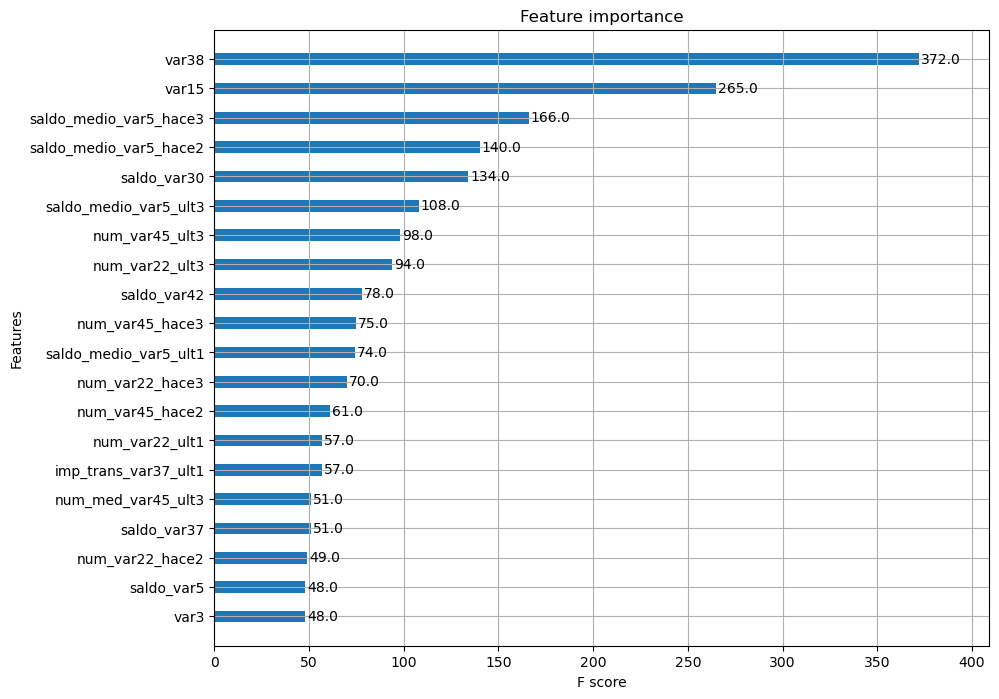

In [37]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15

> **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

In [38]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score)) # 약 0.8390

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

In [39]:
## HyperOpt를 이용해 하이퍼 파라미터 튜닝
# 검색 공간 설정
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves',32,64,1),
                    'max_depth': hp.quniform('max_depth',100,160,1),
                    'min_child_samples': hp.quniform('min_child_samples',60,100,1),
                    'subsample': hp.uniform('subsample',0.7,1),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.2)}

# 목적함수 설정
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=100,
                             num_leaves=int(search_space['num_leaves']),
                             max_depth=int(search_space['max_depth']),
                             min_child_samples=int(search_space['min_child_samples']),
                             subsample=search_space['subsample'],
                             learning_rate=search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                    eval_set=[(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [40]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 오출. max_evals 지정된 횟수만큼 반복 후 목적 함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
           space=lgbm_search_space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[1]	training's auc: 0.82736	training's binary_logloss: 0.162294	valid_1's auc: 0.804818	valid_1's binary_logloss: 0.163544
[2]	training's auc: 0.828309	training's binary_logloss: 0.160269	valid_1's auc: 0.804585	valid_1's binary_logloss: 0.161866
[3]	training's auc: 0.833368	training's binary_logloss: 0.158478	valid_1's auc: 0.806871	valid_1's binary_logloss: 0.16038
[4]	training's auc: 0.834671	training's binary_logloss: 0.156852	valid_1's auc: 0.80706	valid_1's binary_logloss: 0.159053
[5]	training's auc: 0.837783	training's binary_logloss: 0.155354	valid_1's auc: 0.811645	valid_1's binary_logloss: 0.157793
[6]	training's auc: 0.839052	training's binary_logloss: 0.153966	valid_1's auc: 0.81271	valid_1's binary_logloss: 0.156635
[7]	training's auc: 0.841216	training's binary_logloss: 0.152691	valid_1's auc: 0.815103	valid_1's binary_logloss: 0.155585
[8]	training's auc: 0.841859	training's binary_logloss: 0.151499	valid_1's auc: 0.814773	valid_1's binary_logloss: 0.154617
[9]	training

In [41]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                         max_depth=int(best['max_depth']),
                         min_child_samples=int(best['min_child_samples']),
                         subsample=round(best['subsample'],5),
                         learning_rate=round(best['learning_rate'],5))

# evaluation metrix를 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_tr, y_tr),(X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.830269	training's binary_logloss: 0.160016	valid_1's auc: 0.807164	valid_1's binary_logloss: 0.161563
[2]	training's auc: 0.836108	training's binary_logloss: 0.156534	valid_1's auc: 0.809893	valid_1's binary_logloss: 0.158638
[3]	training's auc: 0.840704	training's binary_logloss: 0.153621	valid_1's auc: 0.814446	valid_1's binary_logloss: 0.156108
[4]	training's auc: 0.842435	training's binary_logloss: 0.151085	valid_1's auc: 0.815227	valid_1's binary_logloss: 0.154041
[5]	training's auc: 0.845406	training's binary_logloss: 0.1489	valid_1's auc: 0.815898	valid_1's binary_logloss: 0.152254
[6]	training's auc: 0.849603	training's binary_logloss: 0.14695	valid_1's auc: 0.820156	valid_1's binary_logloss: 0.150615
[7]	training's auc: 0.85132	training's binary_logloss: 0.145263	valid_1's auc: 0.820402	valid_1's binary_logloss: 0.149259
[8]	training's auc: 0.852606	training's binary_logloss: 0.143743	valid_1's auc: 0.820768	valid_1's binary_logloss: 0.148069
[9]	training

- 0.8390 -> 하이퍼 파라미터 튜닝 이후 -> 0.8414
- 상대적으로 빠른 학습시간 > 추가적인 하이퍼 파라미터 튜닝을 고려해 볼 수 있음